In [1]:
from metro_utils import graph, extract_stations, pairs2rails, subsets, total_distance, gen_distance_matrix
from station import Station
from city import City
from collections import defaultdict as dd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [23]:
N_STATIONS = 6
kinds = ['square', 'square', 'circle', 'circle', 'triangle', 'triangle', 'star']

# Can get rid of locations parameter
city = City(N_STATIONS)
stations = city.stations

# Stage 0
TSP

$$\begin{aligned}
&z=\min \sum_{i=1}^{n} \sum_{j=1}^{n} c_{i j} x_{i j} \\
&\text { s.t. } \\
&\sum_{j=1}^{n} x_{i j}=1, \quad i \in I, \\
&\sum_{i=1}^{n} x_{i j}=1, \quad j \in I, \\
&\sum_{i \in S}\sum_{j \in S} x_{ij} \leq |S|-1, \qquad S \subset I, 2 \leq |S| \leq n-1, \\
&x_{i j} \in\{0,1\}, \quad i, j=1, \ldots, n.
\end{aligned}$$

In [24]:
dist = gen_distance_matrix(city)
S = list(range(N_STATIONS))
subs = subsets(S)

In [25]:
import gurobipy as gp
from gurobipy import GRB

m = gp.Model()

x = m.addVars(N_STATIONS, N_STATIONS, vtype=GRB.INTEGER, name="x")

m.setObjective(gp.quicksum(dist[s1, s2]*x[s1, s2] for s1 in S for s2 in S if s1 != s2), GRB.MINIMIZE)

# leave each station only once
m.addConstrs(gp.quicksum(x[s1, s2] for s1 in S if s1 != s2 ) == 1 for s2 in S)
# enter each station only once
m.addConstrs(gp.quicksum(x[s1, s2] for s2 in S if s1 != s2 ) == 1 for s1 in S)
# Subtour elimination constraints
for sub in subs:
    m.addConstr(gp.quicksum(x[s1, s2] for s1 in sub for s2 in sub if s1 != s2) <= len(sub) - 1)

m.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 47 rows, 36 columns and 210 nonzeros
Model fingerprint: 0x4ad8f8fa
Variable types: 0 continuous, 36 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 9e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 3.3818172
Presolve removed 0 rows and 6 columns
Presolve time: 0.00s
Presolved: 47 rows, 30 columns, 210 nonzeros
Variable types: 0 continuous, 30 integer (30 binary)

Root relaxation: objective 2.530871e+00, 12 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       2.5308713    2.53087  0.00%     -    0s

Explored 1 nodes (12 simplex iterations) in 0.01 

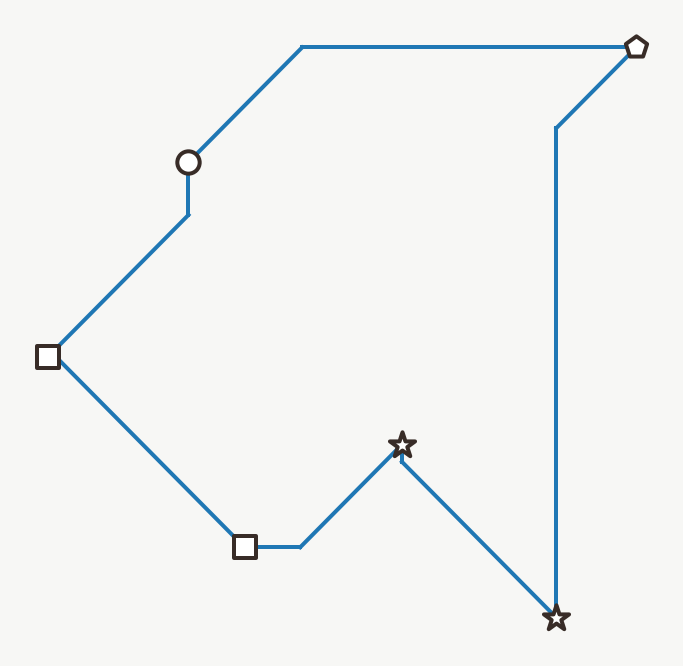

In [26]:
best = pairs2rails([extract_stations(v.varName, city) for v in m.getVars() if v.x > 1e-6])
graph(stations, best)

# Stage 1
Multi-Depot Multiple Traveling Salesman MmTSP

$$\begin{aligned}
&\text{Min (leaving cost + entering cost for each depot) + (path cost for non-depot arcs)} \\
&z=\min \sum_{k \in D} \sum_{j \in V} (c_{kj} x_{kjk} + c_{jk} x_{jkk}) + \sum_{k \in D} \sum_{i \in V} \sum_{j \in V} c_{ij} x_{ijk}\\
&\text { s.t. } \\
&\text{Exactly }m_k\text{ salesmen depart from each depot (in our case }m_k=1) \\
&\sum_{j \in V} x_{kjk} = m_k, \quad k \in D \\
&\text{Number of (Arcs from depot + arcs from any other station) = 1, i.e. each station only has one incoming arc} \\
&\sum_{k \in D} x_{kjk} + \sum_{k \in D}\sum_{i \in V}x_{ijk} = 1, \quad j \in V \\
&\text{} \\
&x_{kjk} + \sum_{i \in V}x_{ijk} - x_{jkk} - \sum_{i \in V}x_{jik}= 0, \quad k \in D, j \in V \\
&\text{Number of arcs coming in = Number of arcs going out for each depot} \\
&\sum_{j \in V} x_{kjk} - \sum_{j \in V}x_{jkk} = 0, \quad k \in D \\
&\text{If station is first on any line, the potential must be = 1. Simultaneously puts in upper limit by bounding largest potential?} \\
&u_i + (L-2)\sum_{k \in D} x_{kik} - \sum_{k \in D}x_{ikk} \leq L-1, \quad i \in V \\
&\text{Ensures last station has sufficient potential to satisfy lower bound requirement?} \\
&u_i + \sum_{k \in D} x_{kik} + (2-K)\sum_{k \in D}x_{ikk} \geq 2, \quad i \in V \\
&\text{Explicitly prohibit lines with just one non-depot station (it says Dep->Stn + Stn->Dep <=1, so can't have both)} \\
&\sum_{k \in D} x_{kik} + \sum_{k \in D}x_{ikk} \leq 1, \quad i \in V \\
&\text{SEC} \\
&u_i - u_j + L\sum_{k \in D} x_{ijk} + (L-2)\sum_{k \in D}x_{jik} \leq L-1, \quad i \neq j, i, j \in V \\
&x_{ijk} \in\{0,1\}, \quad i, j \in V, k \in D\\
&u_{i} \geq 0, \quad i \in V
\end{aligned}$$



In [27]:
# Fixed-Destination
# Unfixed, can have overlapping stations/cities

In [28]:
S

[0, 1, 2, 3, 4, 5]

In [29]:
import gurobipy as gp
from gurobipy import GRB

M = 2
D = S[:M]
V = S[M:]
K = 1#3
L = 100#N_STATIONS - (M-1)*K
mk = 1 # Num trains from kth depot

m = gp.Model()

x = m.addVars(N_STATIONS, N_STATIONS, M, vtype=GRB.INTEGER, name="x")
u = m.addVars(N_STATIONS, vtype=GRB.INTEGER, name="u")

m.setObjective(gp.quicksum(dist[k, j]*x[k, j, k] + dist[j, k]*x[j, k, k] for k in D for j in V) +
               gp.quicksum(dist[i, j]*x[i, j, k] for k in D for j in V for i in V), GRB.MINIMIZE)

# 2
m.addConstrs(gp.quicksum(x[k, j, k] for j in V) == mk for k in D)
# 3
m.addConstrs(gp.quicksum(x[k, j, k] for k in D) + gp.quicksum(x[i, j, k] for k in D for i in V) == 1 for j in V)
# 4
m.addConstrs(x[k, j, k] + gp.quicksum(x[i, j, k] for i in V) - x[j, k, k] - 
             gp.quicksum(x[j, i, k] for i in V) == 0 for k in D for j in V)
# 5
m.addConstrs(gp.quicksum(x[k, j, k] for j in V) - gp.quicksum(x[j, k, k] for j in V) == 0 for k in D)
# 6
m.addConstrs(u[i] + (L - 2)*gp.quicksum(x[k, i, k] for k in D) - 
             gp.quicksum(x[i, k, k] for k in D) <= L - 1 for i in V)
# 7
m.addConstrs(u[i] + gp.quicksum(x[k, i, k] for k in D) + (2 - K)*gp.quicksum(x[i, k, k] for k in D) >= 2 for i in V)
# 8
m.addConstrs(gp.quicksum(x[k, i, k] for k in D) + gp.quicksum(x[i, k, k] for k in D) <= 1 for i in V)
# 9
m.addConstrs(u[i] - u[j] + L*gp.quicksum(x[i, j, k] for k in D) + 
             (L - 2)*gp.quicksum(x[j, i, k] for k in D) <= L - 1 for i in V for j in V if i != j)
# 10
m.addConstrs(x[i, i, k] == 0 for i in V for k in D)

m.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 48 rows, 78 columns and 264 nonzeros
Model fingerprint: 0x1f898d87
Variable types: 0 continuous, 78 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [2e-01, 9e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 3.1847547
Presolve removed 8 rows and 34 columns
Presolve time: 0.00s
Presolved: 40 rows, 44 columns, 240 nonzeros
Variable types: 0 continuous, 44 integer (40 binary)

Root relaxation: objective 2.530871e+00, 17 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.53087    0   12    3.18475    2.53087  20.5%     -    0s
H    0     0                       3.1555773    2

In [30]:
for var in m.getVars():
    if var.x > 1e-6:
        print(var.varName, var.x)

x[0,2,0] 1.0
x[1,3,1] 1.0
x[2,4,0] 1.0
x[3,5,1] 1.0
x[4,0,0] 1.0
x[5,1,1] 1.0
u[2] 1.0
u[3] 1.0
u[4] 2.0
u[5] 2.0


In [31]:
RAIL = 2

connections = [extract_stations(v.varName, city) for v in m.getVars() if v.x > 1e-6 and v.varName[0] == 'x']

rail_pairs = dd(list)
for connection in connections:
    rail_pairs[connection[RAIL]].append(connection[:2])
    
rail_pairs

defaultdict(list, {0: [[0, 2], [2, 4], [4, 0]], 1: [[1, 3], [3, 5], [5, 1]]})

In [32]:
rails = []

for rail, pairs in rail_pairs.items():
    rails.append(pairs2rails(pairs))
    
rails

[[0, 2, 4, 0], [1, 3, 5, 1]]

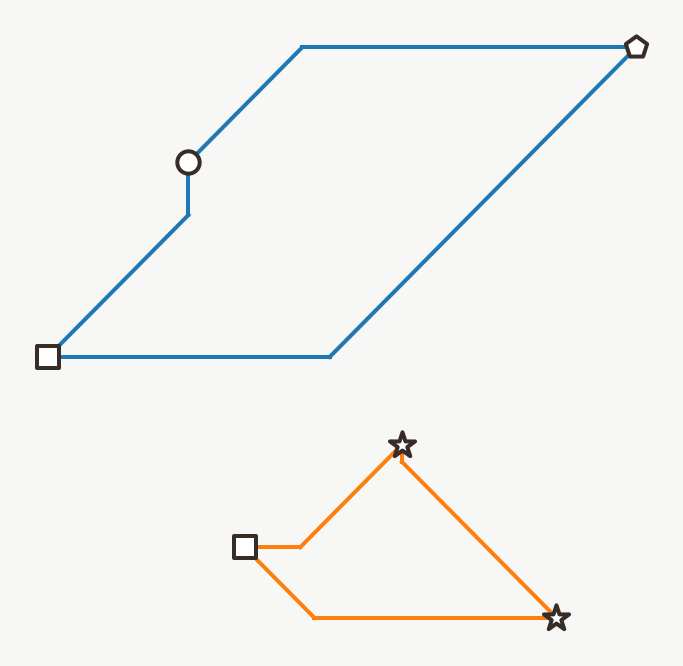

In [33]:
graph(stations, rails)

# Stage 1.1

In [34]:
import gurobipy as gp
from gurobipy import GRB

M = 2
D = S[:M]
V = S[M:]
K = 1#3
L = 100#N_STATIONS - (M-1)*K
mk = 1 # Num trains from kth depot

def run_model(D, V):
    D2k = {s: i for i, s in enumerate(D)}
    
    m = gp.Model()
    
    m.setParam('OutputFlag', 0)

    x = m.addVars(N_STATIONS, N_STATIONS, M, vtype=GRB.INTEGER, name="x")
    u = m.addVars(N_STATIONS, vtype=GRB.INTEGER, name="u")

    m.setObjective(gp.quicksum(dist[k, j]*x[k, j, D2k[k]] + dist[j, k]*x[j, k, D2k[k]] for k in D for j in V) +
                   gp.quicksum(dist[i, j]*x[i, j, D2k[k]] for k in D for j in V for i in V), GRB.MINIMIZE)

    # 2
    m.addConstrs(gp.quicksum(x[k, j, D2k[k]] for j in V) == mk for k in D)
    # 3
    m.addConstrs(gp.quicksum(x[k, j, D2k[k]] for k in D) + gp.quicksum(x[i, j, D2k[k]] for k in D for i in V) == 1 for j in V)
    # 4
    m.addConstrs(x[k, j, D2k[k]] + gp.quicksum(x[i, j, D2k[k]] for i in V) - x[j, k, D2k[k]] - 
                 gp.quicksum(x[j, i, D2k[k]] for i in V) == 0 for k in D for j in V)
    # 5
    m.addConstrs(gp.quicksum(x[k, j, D2k[k]] for j in V) - gp.quicksum(x[j, k, D2k[k]] for j in V) == 0 for k in D)
    # 6
    m.addConstrs(u[i] + (L - 2)*gp.quicksum(x[k, i, D2k[k]] for k in D) - 
                 gp.quicksum(x[i, k, D2k[k]] for k in D) <= L - 1 for i in V)
    # 7
    m.addConstrs(u[i] + gp.quicksum(x[k, i, D2k[k]] for k in D) + (2 - K)*gp.quicksum(x[i, k, D2k[k]] for k in D) >= 2 for i in V)
    # 8
    m.addConstrs(gp.quicksum(x[k, i, D2k[k]] for k in D) + gp.quicksum(x[i, k, D2k[k]] for k in D) <= 1 for i in V)
    # 9
    m.addConstrs(u[i] - u[j] + L*gp.quicksum(x[i, j, D2k[k]] for k in D) + 
                 (L - 2)*gp.quicksum(x[j, i, D2k[k]] for k in D) <= L - 1 for i in V for j in V if i != j)
    # 10
    m.addConstrs(x[i, i, D2k[k]] == 0 for i in V for k in D)

    m.optimize()
    
    return m

run_model(D, V).objVal

2.7571112257447346

In [35]:
from itertools import combinations
from tqdm import tqdm

minn = 1e12
best = None
for comb in tqdm(list(combinations(S, M))):
    D = list(comb)
    V = S[:]
    for s in D:
        V.remove(s)
        
    m = run_model(D, V)
    
    if m.objVal < minn:
        minn = m.objVal
        best = m

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 143.10it/s]


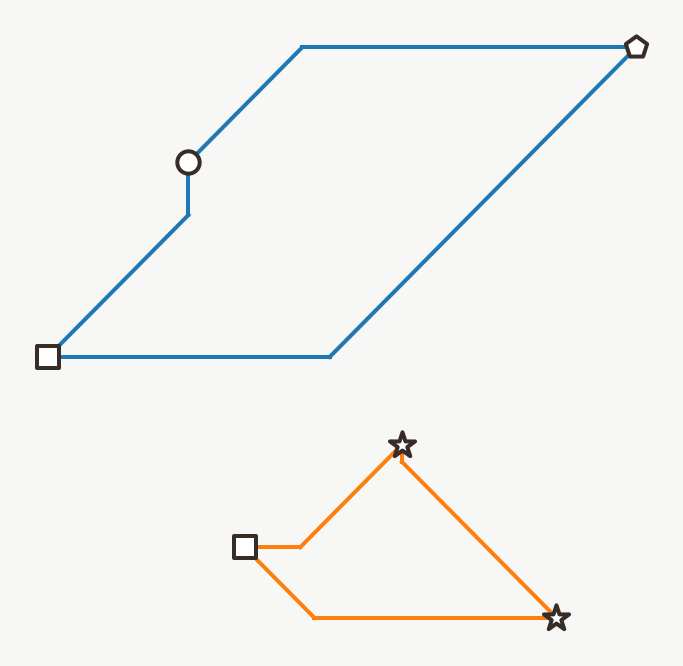

In [36]:
RAIL = 2

connections = [extract_stations(v.varName, city) for v in best.getVars() if v.x > 1e-6 and v.varName[0] == 'x']

rail_pairs = dd(list)
for connection in connections:
    rail_pairs[connection[RAIL]].append(connection[:2])
    
rails = []

for rail, pairs in rail_pairs.items():
    rails.append(pairs2rails(pairs))
    
graph(stations, rails)

# Stage 2

In [37]:
import networkx as nx

def cost(rails):
    # Find distance between all pairs of stations
    G=nx.Graph()

    elist = []
    for rail in rails:
        start = rail[0]
        for end in rail[1:]:
            elist.append((start, end, dist[start.id, end.id]))
            start = end    

    G.add_weighted_edges_from(elist)
    all_paths = list(nx.all_pairs_shortest_path(G))
    
    
    station_dists = []
    all_kinds = {s.kind for s in stations}

    # For each starting station
    for start, paths in all_paths:

        distances = {kind: 1e12 for kind in all_kinds}

        # Get its kind
        for end, path in paths.items():
            # For each other station: If kind is different
            if start.kind != end.kind:
                # Work out distance to that station and retain if min
                distances[end.kind] = min(distances[end.kind], total_distance(path))

        station_dists.append(sum(distances.values()))

    return sum(station_dists)

In [38]:
from math import factorial
from itertools import permutations

def brute_force_tsp(stations):
    max_dist = 1e15
    best = None

    for perm in tqdm(permutations(stations), total=factorial(N_STATIONS)):
        perm = list(perm)
        perm.append(perm[0])
        perm = [perm]
        
        dist = cost(perm)
        if dist < max_dist:
            max_dist = dist
            best = perm
            
    return best

a = brute_force_tsp(stations)

100%|██████████████████████████████████████████████████████████████████████████████| 720/720 [00:00<00:00, 5834.71it/s]


In [39]:
a

[[2, 4, 1, 3, 5, 0, 2]]

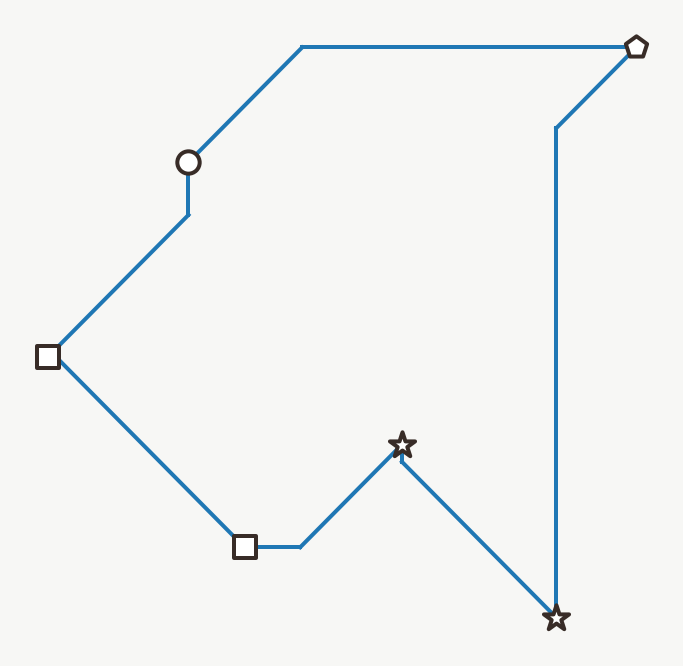

In [40]:
graph(stations, a)

In [41]:
from math import factorial

def brute_force_tsp(stations):
    ''' This doesn't allow for loops or overlapping sections but it should '''
    max_dist = 1e15
    best = None

    for perm in tqdm(permutations(stations), total=factorial(N_STATIONS)):
        perm = list(perm)
        perm.append(perm[0])
        for split in range(2, len(perm)):
            split = [perm[:split], perm[split:]] 

            dist = cost(split)
            if dist < max_dist:
                max_dist = dist
                best = split
            
    return best

a = brute_force_tsp(stations)

100%|██████████████████████████████████████████████████████████████████████████████| 720/720 [00:00<00:00, 1161.28it/s]


In [42]:
a

[[0, 2, 4, 5], [1, 3, 0]]

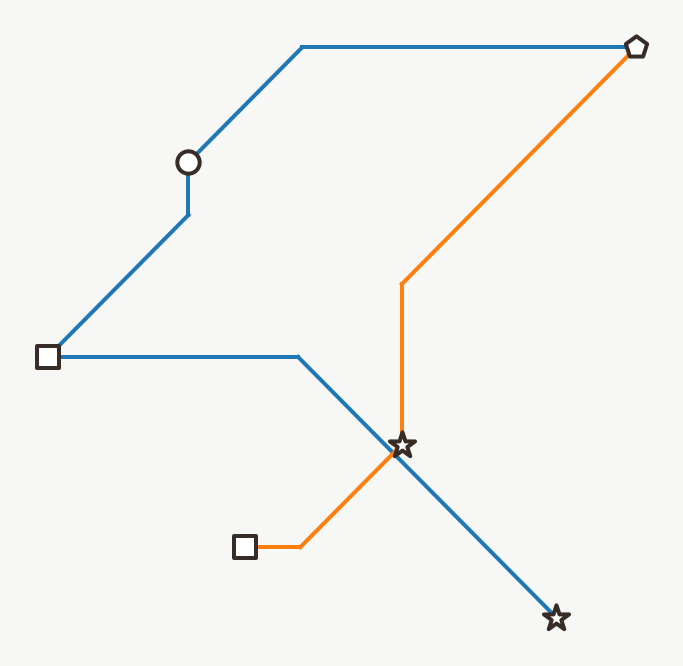

In [43]:
graph(stations, a)